#  WNS Analytics Wizard 2019 CONTEST

**AIM** : To predict whether the ad will be clicked by the user who enters into Partner websites, using the Ad data and the persons history on the ZAP website.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# importing the needed libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
!ls "/content/drive/My Drive/Hackathon/train"

item_data.csv  __MACOSX  train_check1.csv  train.csv  view_log.csv


In [0]:
# Loading the Train and Test Files.
train = pd.read_csv("/content/drive/My Drive/Hackathon/train/train.csv")
item = pd.read_csv("/content/drive/My Drive/Hackathon/train/item_data.csv")
view_log = pd.read_csv("/content/drive/My Drive/Hackathon/train/view_log.csv")
test = pd.read_csv("/content/drive/My Drive/Hackathon/test/test.csv")

In [0]:
#Viewing Train Data
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [0]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [0]:
item.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [0]:
# Since the Log Data contains only item Id of product we will left join product attributes with User Log history to get a required dataset
product_view_log = pd.merge(view_log, item, on="item_id", how="left")
product_view_log.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [0]:
# Visualizing how test data looks like.
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [0]:
train['is_click'].value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [0]:
print ("Ad's clicked to Not clicked ratio is: "+ str(train['is_click'].value_counts()[1]/train['is_click'].value_counts()[0]))

Ad's clicked to Not clicked ratio is: 0.04790361063211421


Approximately 4.8% ads displayed were clicked, so what we have here is a imbalanced binary classification problem.

Checking Time Period of the Data

In [0]:
# Let us Convert the Dates into DateTime Object. 
product_view_log['server_time'] = pd.to_datetime(product_view_log['server_time'])
train['impression_time'] = pd.to_datetime(train['impression_time'])
test['impression_time'] = pd.to_datetime(test['impression_time'])

In [0]:
print ("User Product logs are available from : " + str(product_view_log['server_time'].min()) + " to " + str(product_view_log['server_time'].max()))
print ("Equivalent to "+ str(product_view_log['server_time'].max()-product_view_log['server_time'].min()))

User Product logs are available from : 2018-10-15 08:58:00 to 2018-12-11 23:59:00
Equivalent to 57 days 15:01:00


In [0]:
print ("Train and test records are available from : " + str(train['impression_time'].min()) + " to " + str(test['impression_time'].max()))
print ("Equivalent to "+ str(test['impression_time'].max()-train['impression_time'].min()))

Train and test records are available from : 2018-11-15 00:00:00 to 2018-12-18 23:59:00
Equivalent to 33 days 23:59:00


In [0]:
print ("Train records are available from : " + str(train['impression_time'].min()) + " to " + str(train['impression_time'].max()))
print ("Equivalent to "+ str(train['impression_time'].max()-train['impression_time'].min()))

Train records are available from : 2018-11-15 00:00:00 to 2018-12-13 07:43:00
Equivalent to 28 days 07:43:00


In [0]:
print ("Test records are available from : " + str(test['impression_time'].min()) + " to " + str(test['impression_time'].max()))
print ("Equivalent to "+ str(test['impression_time'].max()-test['impression_time'].min()))

Test records are available from : 2018-12-12 00:00:00 to 2018-12-18 23:59:00
Equivalent to 6 days 23:59:00


**Observations** <br>
1) We have previous one month view history of users in the ZAP Website before making Predictions.<br>
2) Training Data is 4 Weeks and Test Data is 1 Week.

# Factors which present in Product View Log may influence the User Ad click.
1) Temporal Factors:<br>
&emsp;a) Time of the Day in which user enters the Partner Website - Both Hours and Parts of the Day <br>
&emsp;&emsp;Morning <br>
&emsp;&emsp;&emsp;&emsp;&emsp;Early morning     5 to 8 am <br>
&emsp;&emsp;&emsp;&emsp;&emsp;Late morning      11 am to 12pm <br>
&emsp;&emsp;Afternoon <br>
&emsp;&emsp;&emsp;&emsp;&emsp;Early afternoon   1 to 3pm <br>
&emsp;&emsp;&emsp;&emsp;&emsp;Late afternoon    4 to 5pm <br>
&emsp;&emsp;Evening<br>
&emsp;&emsp;&emsp;&emsp;&emsp;Early evening         5 to 7 pm <br>
&emsp;&emsp;&emsp;&emsp;&emsp;Late evening          5 pm to 9 pm <br>
&emsp;&emsp;Night                 9 pm to 4 am <br>
&emsp;b) Number of times user visited the site in last 3 hours, 6 hours, 12 hours, 1 day, 2 days, 3 days, 1 week and 1 month.<br>
&emsp;c) Number of products user viewed in the site for last 3 hours, 6 hours, 12 hours, 1 day, 2 days, 3 days, 1 week and 1 month.<br>
&emsp;d) Number of products user viewed by the user in the last session<br> 
&emsp;e) Number of times user was shown the Ad and Number of times user clicked the Ad as Click Ratio of user<br> 
&emsp;f) Last 5 products viewed by the user by the time ad was shown. Product 1, Product 2, Product 3, Product 4, Product 5.<br> 
&emsp;g) Time spent by the user on a site for last 5 sessions as session1, session2, session3, session4, session5.<br> 
&emsp;h) Day of the Week & Weekend or not weekend<br> 

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null datetime64[ns]
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 12.7+ MB


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 6 columns):
impression_id      90675 non-null object
impression_time    90675 non-null datetime64[ns]
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.2+ MB


In [0]:
view_log.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
server_time    3118622 non-null object
device_type    3118622 non-null object
session_id     3118622 non-null int64
user_id        3118622 non-null int64
item_id        3118622 non-null int64
dtypes: int64(3), object(2)
memory usage: 119.0+ MB


In [0]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Data columns (total 6 columns):
item_id         132761 non-null int64
item_price      132761 non-null int64
category_1      132761 non-null int64
category_2      132761 non-null int64
category_3      132761 non-null int64
product_type    132761 non-null int64
dtypes: int64(6)
memory usage: 6.1 MB


In [0]:
product_view_log.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118622 entries, 0 to 3118621
Data columns (total 10 columns):
server_time     3118622 non-null datetime64[ns]
device_type     3118622 non-null object
session_id      3118622 non-null int64
user_id         3118622 non-null int64
item_id         3118622 non-null int64
item_price      3116840 non-null float64
category_1      3116840 non-null float64
category_2      3116840 non-null float64
category_3      3116840 non-null float64
product_type    3116840 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 261.7+ MB


In [0]:
product_view_log[product_view_log['product_type'].isnull()].head(5)

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
910,2018-10-15 09:26:00,android,385038,2762,62896,NaN,NaN,NaN,NaN,NaN
992,2018-10-15 09:29:00,android,414756,37689,62896,NaN,NaN,NaN,NaN,NaN
1092,2018-10-15 09:31:00,android,908667,83161,78925,NaN,NaN,NaN,NaN,NaN
1094,2018-10-15 09:31:00,android,414756,37689,62896,NaN,NaN,NaN,NaN,NaN
6271,2018-10-15 11:48:00,android,974431,17095,62896,NaN,NaN,NaN,NaN,NaN


In [0]:
print("Item Id's of Product Not Available and their Counts: ")
product_view_log['item_id'][product_view_log['product_type'].isnull()].unique(), len(product_view_log['item_id'][product_view_log['product_type'].isnull()].unique())

Item Id's of Product Not Available and their Counts: 


(array([ 62896,  78925, 120924,  35796, 127421,  26822,  38726,  99088,
        100584,  88475, 123800,  53487,  81316, 132148,  70617,  19919,
         46555,  60936, 127932,  13054, 110346,  79532,    873,  44868,
        114373,  91436,  72477,  44666,  82996,  55764,  51486,  77510,
         78710,  45328,  96367, 121588, 113429,  76689,  40687,  33661,
        115841,  12689,  64358,  48098, 105071,   9346,  57229,  18127,
        121118,   7973,  37474,  31100,  38583, 120071,   2731,  46949,
          9444,  63773, 132645,  54461,  76183, 103496, 127454,  72294,
        125024,  86355,  46686,  91856,  11454, 103132,  97451,   8236,
         55187, 122449,   1092,   5969,  39013,  47442, 102063,  36034,
        127479, 117837,  57470,  92171,  61982,  28688, 115953,  37908,
         42356, 118692, 115647,  90820, 127556,  19281, 116150,   6041,
        115760,  55390,  62676,  22625,  67806]), 101)

Product Attributes for 101 items when present in 1782 logs were unavialable

In [0]:
product_view_log['server_time'][product_view_log['product_type'].isnull()].dt.month.value_counts()

11    968
10    494
12    320
Name: server_time, dtype: int64

Since the Product information unavailablity is equal in all months with amount of data present in each month, We will not use this information while taking temporal features with Products.

In [0]:
product_view_log = product_view_log[product_view_log['product_type'].notnull()].reset_index(drop=True)

**Let us Start Extracting the Derived Features.**

Adding Part of the Day and Hour of the Day to Server time

In [0]:
product_view_log['Hour_of_the_day'] = product_view_log['server_time'].dt.hour
product_view_log['Part_of_the_day'] = None
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=5)&(product_view_log['Hour_of_the_day']<=8)] = "Early Morning"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=9)&(product_view_log['Hour_of_the_day']<=10)] = "Middle Morning"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=11)&(product_view_log['Hour_of_the_day']<=12)] = "Late Morning"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=13)&(product_view_log['Hour_of_the_day']<=15)] = "Early Afternoon"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=16)&(product_view_log['Hour_of_the_day']<=17)] = "Late Afternoon"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=18)&(product_view_log['Hour_of_the_day']<=19)] = "Early Evening"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=20)&(product_view_log['Hour_of_the_day']<=21)] = "Late Evening"
product_view_log['Part_of_the_day'][(product_view_log['Hour_of_the_day']>=22)|(product_view_log['Hour_of_the_day']<=4)] = "Night"
product_view_log['Part_of_the_day'].value_counts()

Night              686607
Early Afternoon    461084
Late Evening       422363
Early Evening      335173
Middle Morning     323229
Late Morning       320134
Late Afternoon     296916
Early Morning      271334
Name: Part_of_the_day, dtype: int64

In [0]:
def product_session_counts(x, timespan_with_unit, count):
    sessions = count
    product_info_extraction_count = count
    #print(x.impression_time, x.user_id, timespan, timespan_unit)
    temp = product_view_log[product_view_log['user_id']==x.user_id]
    session_count_with_time_list = []
    category1_seen_count_with_time_list = []
    category2_seen_count_with_time_list = []
    category3_seen_count_with_time_list = []
    product_type_seen_count_with_time_list = []
    item_id_seen_count_with_time_list = []
    category1_seen_count_with_session = []
    category2_seen_count_with_session = []
    category3_seen_count_with_session = []
    product_type_seen_count_with_session = []
    item_id_seen_count_with_session = []
    average_price_of_product_with_session =[]
    device_type_in_each_session = []
    hour_of_the_day_each_session=[]
    part_of_the_day_each_session=[]
    time_spent_surfing_each_session=[]
    last_visited_product_items = []
    last_visited_product_types = []
    last_visited_product_categories_1 = []
    last_visited_product_categories_2 = []
    last_visited_product_categories_3 = []
    last_visited_product_prices = []
    
    
    for timespan, timespan_unit in timespan_with_unit:
        session_count_with_time_list.append(temp['session_id'][(temp['server_time']<x.impression_time)&(temp['server_time']>(x['impression_time'] - pd.to_timedelta(timespan, unit=timespan_unit)))].nunique())
        category1_seen_count_with_time_list.append(temp['category_1'][(temp['server_time']<x.impression_time)&(temp['server_time']>(x['impression_time'] - pd.to_timedelta(timespan, unit=timespan_unit)))].nunique())
        category2_seen_count_with_time_list.append(temp['category_2'][(temp['server_time']<x.impression_time)&(temp['server_time']>(x['impression_time'] - pd.to_timedelta(timespan, unit=timespan_unit)))].nunique())
        category3_seen_count_with_time_list.append(temp['category_3'][(temp['server_time']<x.impression_time)&(temp['server_time']>(x['impression_time'] - pd.to_timedelta(timespan, unit=timespan_unit)))].nunique())
        product_type_seen_count_with_time_list.append(temp['product_type'][(temp['server_time']<x.impression_time)&(temp['server_time']>(x['impression_time'] - pd.to_timedelta(timespan, unit=timespan_unit)))].nunique())
        item_id_seen_count_with_time_list.append(temp['item_id'][(temp['server_time']<x.impression_time)&(temp['server_time']>(x['impression_time'] - pd.to_timedelta(timespan, unit=timespan_unit)))].nunique())
    
    temp = temp[temp['server_time']<x.impression_time]
    temp.sort_values(by='server_time', inplace=True, ascending=False)
    #print(temp['session_id'].unique()[0:sessions])
    for i in temp['session_id'].unique()[0:sessions]:
        category1_seen_count_with_session.append(temp['category_1'][temp['session_id']==i].nunique())
        category2_seen_count_with_session.append(temp['category_2'][temp['session_id']==i].nunique())
        category3_seen_count_with_session.append(temp['category_3'][temp['session_id']==i].nunique())
        product_type_seen_count_with_session.append(temp['product_type'][temp['session_id']==i].nunique())
        item_id_seen_count_with_session.append(temp['item_id'][temp['session_id']==i].nunique())
        average_price_of_product_with_session.append(temp['item_id'][temp['session_id']==i].mean())
        device_type_in_each_session.append(temp['device_type'][temp['session_id']==i].unique()[0])
        hour_of_the_day_each_session.append(temp['Hour_of_the_day'][temp['session_id']==i].unique()[0])
        part_of_the_day_each_session.append(temp['Part_of_the_day'][temp['session_id']==i].unique()[0])
        time_spent_surfing_each_session.append(((temp['server_time'][temp['session_id']==i].max())-(temp['server_time'][temp['session_id']==i].min())).seconds)
        
    category1_seen_count_with_session = (category1_seen_count_with_session+([None]*sessions))[:sessions]
    category2_seen_count_with_session = (category2_seen_count_with_session+([None]*sessions))[:sessions]
    category3_seen_count_with_session = (category3_seen_count_with_session+([None]*sessions))[:sessions]
    product_type_seen_count_with_session = (product_type_seen_count_with_session+([None]*sessions))[:sessions]
    item_id_seen_count_with_session = (item_id_seen_count_with_session+([None]*sessions))[:sessions]
    average_price_of_product_with_session = (average_price_of_product_with_session+([None]*sessions))[:sessions]
    device_type_in_each_session = (device_type_in_each_session+([None]*sessions))[:sessions]
    part_of_the_day_each_session = (part_of_the_day_each_session+([None]*sessions))[:sessions]
    hour_of_the_day_each_session = (hour_of_the_day_each_session+([None]*sessions))[:sessions]
    time_spent_surfing_each_session = (time_spent_surfing_each_session+([None]*sessions))[:sessions]
    
    # Last Visited Product Attribute Details
    
    last_visited_product_items = (temp['item_id'].unique().tolist()+([None]*product_info_extraction_count))[0:product_info_extraction_count]
    last_visited_product_types = (temp['product_type'].unique().tolist()+([None]*product_info_extraction_count))[0:product_info_extraction_count]
    last_visited_product_categories_1 = (temp['category_1'].unique().tolist()+([None]*product_info_extraction_count))[0:product_info_extraction_count]
    last_visited_product_categories_2 = (temp['category_2'].unique().tolist()+([None]*product_info_extraction_count))[0:product_info_extraction_count]
    last_visited_product_categories_3 = (temp['category_3'].unique().tolist()+([None]*product_info_extraction_count))[0:product_info_extraction_count]
    last_visited_product_prices = (temp['item_price'].unique().tolist()+([None]*product_info_extraction_count))[0:product_info_extraction_count]
    
    return (session_count_with_time_list +  category1_seen_count_with_time_list + category2_seen_count_with_time_list + 
    category3_seen_count_with_time_list + product_type_seen_count_with_time_list + item_id_seen_count_with_time_list +
    category1_seen_count_with_session + category2_seen_count_with_session + category3_seen_count_with_session + 
    product_type_seen_count_with_session + item_id_seen_count_with_session + average_price_of_product_with_session +
    device_type_in_each_session + hour_of_the_day_each_session + part_of_the_day_each_session + 
    time_spent_surfing_each_session + last_visited_product_items + last_visited_product_types +
    last_visited_product_categories_1 + last_visited_product_categories_2 + last_visited_product_categories_3 +
    last_visited_product_prices)

In [0]:
train.shape

(237609, 7)

In [0]:
%%time
#Number of times user visited the site in last 3 hours, 6 hours, 12 hours, 1 day, 2 days, 3 days, 1 week and 30 days.

column_list=['site_visit_count_last_3_hours', 'site_visit_count_last_6_hours',
            'site_visit_count__last_12_hours', 'site_visit_count_last_1_day',
            'site_visit_count_last_2_days', 'site_visit_count_last_3_days',
            'site_visit_count_last_1_week', 'site_visit_count_last_1_month',
            'category1_seen_count_last_3_hours', 'category1_seen_count_last_6_hours',
            'category1_seen_count__last_12_hours', 'category1_seen_count_last_1_day',
            'category1_seen_count_last_2_days', 'category1_seen_count_last_3_days',
            'category1_seen_count_last_1_week', 'category1_seen_count_last_1_month',
            'category2_seen_count_last_3_hours', 'category2_seen_count_last_6_hours',
            'category2_seen_count__last_12_hours', 'category2_seen_count_last_1_day',
            'category2_seen_count_last_2_days', 'category2_seen_count_last_3_days',
            'category2_seen_count_last_1_week', 'category2_seen_count_last_1_month',
            'category3_seen_count_last_3_hours', 'category3_seen_count_last_6_hours',
            'category3_seen_count__last_12_hours', 'category3_seen_count_last_1_day',
            'category3_seen_count_last_2_days', 'category3_seen_count_last_3_days',
            'category3_seen_count_last_1_week', 'category3_seen_count_last_1_month',
            'product_type_seen_count_last_3_hours', 'product_type_seen_count_last_6_hours',
            'product_type_seen_count__last_12_hours', 'product_type_seen_count_last_1_day',
            'product_type_seen_count_last_2_days', 'product_type_seen_count_last_3_days',
            'product_type_seen_count_last_1_week', 'product_type_seen_count_last_1_month',
            'product_item_seen_count_last_3_hours', 'product_item_seen_count_last_6_hours',
            'product_item_seen_count__last_12_hours', 'product_item_seen_count_last_1_day',
            'product_item_seen_count_last_2_days', 'product_item_seen_count_last_3_days',
            'product_item_seen_count_last_1_week', 'product_item_seen_count_last_1_month',
            'category1_seen_count_with_session1', 'category1_seen_count_with_session2',
            'category1_seen_count_with_session3', 'category1_seen_count_with_session4', 
            'category1_seen_count_with_session5', 'category2_seen_count_with_session1',
            'category2_seen_count_with_session2', 'category2_seen_count_with_session3',
            'category2_seen_count_with_session4', 'category2_seen_count_with_session5',
            'category3_seen_count_with_session1', 'category3_seen_count_with_session2',
            'category3_seen_count_with_session3', 'category3_seen_count_with_session4', 
            'category3_seen_count_with_session5', 'product_type_seen_count_with_session1',
            'product_type_seen_count_with_session2', 'product_type_seen_count_with_session3',
            'product_type_seen_count_with_session4', 'product_type_seen_count_with_session5',
            'item_id_seen_count_with_session1', 'item_id_seen_count_with_session2',
            'item_id_seen_count_with_session3', 'item_id_seen_count_with_session4', 
            'item_id_seen_count_with_session5', 'average_price_of_product_seen_count_with_session1',
            'average_price_of_product_seen_count_with_session2', 'average_price_of_product_seen_count_with_session3',
            'average_price_of_product_seen_count_with_session4', 'average_price_of_product_seen_count_with_session5',
            'device_type_seen_count_with_session1', 'device_type_seen_count_with_session2',
            'device_type_seen_count_with_session3', 'device_type_seen_count_with_session4', 
            'device_type_seen_count_with_session5', 'hour_of_the_day_seen_count_with_session1',
            'hour_of_the_day_seen_count_with_session2', 'hour_of_the_day_seen_count_with_session3',
            'hour_of_the_day_seen_count_with_session4', 'hour_of_the_day_seen_count_with_session5',
            'part_of_the_day_seen_count_with_session1', 'part_of_the_day_seen_count_with_session2',
            'part_of_the_day_seen_count_with_session3', 'part_of_the_day_seen_count_with_session4', 
            'part_of_the_day_seen_count_with_session5', 'time_spent_surfing_each_session_with_session1',
            'time_spent_surfing_each_session_with_session2', 'time_spent_surfing_each_session_with_session3',
            'time_spent_surfing_each_session_with_session4', 'time_spent_surfing_each_session_with_session5',
            'last_visited_product_item1', 'last_visited_product_item2',
            'last_visited_product_item3', 'last_visited_product_item4', 
            'last_visited_product_item5', 'last_visited_product_type1',
            'last_visited_product_type2', 'last_visited_product_type3',
            'last_visited_product_type4', 'last_visited_product_type5',
            'last_visited_product_category1_1', 'last_visited_product_category1_2',
            'last_visited_product_category1_3', 'last_visited_product_category1_4', 
            'last_visited_product_category1_5', 'last_visited_product_category2_1',
            'last_visited_product_category2_2', 'last_visited_product_category2_3',
            'last_visited_product_category2_4', 'last_visited_product_category2_5',
            'last_visited_product_category3_1', 'last_visited_product_category3_2',
            'last_visited_product_category3_3', 'last_visited_product_category3_4', 
            'last_visited_product_category3_5', 'last_visited_product_price_1',
            'last_visited_product_price_2', 'last_visited_product_price_3',
            'last_visited_product_price_4', 'last_visited_product_price_5']

#Train
user_visited_count_train_df = train[['impression_time','user_id']].apply(lambda x: product_session_counts(x, [(3,"h"), (6, "h"), (12, "h"), (1, "d") ,(2, "d"), (3, "d"), (7, "d"), (30, "d")], 5 ), axis=1)
user_visited_count_train_df = (pd.DataFrame(user_visited_count_train_df.values.tolist()))
user_visited_count_train_df.columns = column_list
train_a = pd.merge(train, user_visited_count_train_df, left_index=True, right_index=True)
train_a.to_csv("/content/drive/My Drive/Hackathon/train/train_check1.csv", index=False)

In [0]:
train_a.head()

In [0]:
#Test
user_visited_count_test_df = test[['impression_time','user_id']].apply(lambda x: product_session_counts(x, [(3,"h"), (6, "h"), (12, "h"), (1, "d") ,(2, "d"), (3, "d"), (7, "d"), (30, "d")], 5 ), axis=1)
user_visited_count_test_df = (pd.DataFrame(user_visited_count_test_df.values.tolist()))
user_visited_count_test_df.columns = column_list
test_a = pd.merge(test, user_visited_count_test_df, left_index=True, right_index=True)
test_a.to_csv("/content/drive/My Drive/Hackathon/test/test_check1.csv", index=False)

In [0]:
train = pd.read_csv("/content/drive/My Drive/Hackathon/train/train_check1.csv")
test = pd.read_csv("/content/drive/My Drive/Hackathon/test/test_check1.csv")

In [4]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 135 columns):
impression_id                                        237609 non-null object
impression_time                                      237609 non-null object
user_id                                              237609 non-null int64
app_code                                             237609 non-null int64
os_version                                           237609 non-null object
is_4G                                                237609 non-null int64
is_click                                             237609 non-null int64
site_visit_count_last_3_hours                        237609 non-null int64
site_visit_count_last_6_hours                        237609 non-null int64
site_visit_count__last_12_hours                      237609 non-null int64
site_visit_count_last_1_day                          237609 non-null int64
site_visit_count_last_2_days                         237609 

In [5]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 134 columns):
impression_id                                        90675 non-null object
impression_time                                      90675 non-null object
user_id                                              90675 non-null int64
app_code                                             90675 non-null int64
os_version                                           90675 non-null object
is_4G                                                90675 non-null int64
site_visit_count_last_3_hours                        90675 non-null int64
site_visit_count_last_6_hours                        90675 non-null int64
site_visit_count__last_12_hours                      90675 non-null int64
site_visit_count_last_1_day                          90675 non-null int64
site_visit_count_last_2_days                         90675 non-null int64
site_visit_count_last_3_days                         90675 non-null int64

In [6]:
train._get_numeric_data().fillna(-99, inplace=True)
train.fillna("NOTAVAILABLE", inplace=True)
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 135 columns):
impression_id                                        237609 non-null object
impression_time                                      237609 non-null object
user_id                                              237609 non-null int64
app_code                                             237609 non-null int64
os_version                                           237609 non-null object
is_4G                                                237609 non-null int64
is_click                                             237609 non-null int64
site_visit_count_last_3_hours                        237609 non-null int64
site_visit_count_last_6_hours                        237609 non-null int64
site_visit_count__last_12_hours                      237609 non-null int64
site_visit_count_last_1_day                          237609 non-null int64
site_visit_count_last_2_days                         237609 

In [7]:
test._get_numeric_data().fillna(-99, inplace=True)
test.fillna("NOTAVAILABLE", inplace=True)
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 134 columns):
impression_id                                        90675 non-null object
impression_time                                      90675 non-null object
user_id                                              90675 non-null int64
app_code                                             90675 non-null int64
os_version                                           90675 non-null object
is_4G                                                90675 non-null int64
site_visit_count_last_3_hours                        90675 non-null int64
site_visit_count_last_6_hours                        90675 non-null int64
site_visit_count__last_12_hours                      90675 non-null int64
site_visit_count_last_1_day                          90675 non-null int64
site_visit_count_last_2_days                         90675 non-null int64
site_visit_count_last_3_days                         90675 non-null int64

In [8]:
train['impression_time'] = pd.to_datetime(train['impression_time'])
train['Hour_of_the_day'] = train['impression_time'].dt.hour
train['Part_of_the_day'] = None
train['Part_of_the_day'][(train['Hour_of_the_day']>=5)&(train['Hour_of_the_day']<=8)] = "Early Morning"
train['Part_of_the_day'][(train['Hour_of_the_day']>=9)&(train['Hour_of_the_day']<=10)] = "Middle Morning"
train['Part_of_the_day'][(train['Hour_of_the_day']>=11)&(train['Hour_of_the_day']<=12)] = "Late Morning"
train['Part_of_the_day'][(train['Hour_of_the_day']>=13)&(train['Hour_of_the_day']<=15)] = "Early Afternoon"
train['Part_of_the_day'][(train['Hour_of_the_day']>=16)&(train['Hour_of_the_day']<=17)] = "Late Afternoon"
train['Part_of_the_day'][(train['Hour_of_the_day']>=18)&(train['Hour_of_the_day']<=19)] = "Early Evening"
train['Part_of_the_day'][(train['Hour_of_the_day']>=20)&(train['Hour_of_the_day']<=21)] = "Late Evening"
train['Part_of_the_day'][(train['Hour_of_the_day']>=22)|(train['Hour_of_the_day']<=4)] = "Night"
train['Part_of_the_day'].value_counts()

Night              66692
Early Afternoon    33285
Late Evening       30683
Early Evening      27741
Late Afternoon     26726
Late Morning       19329
Middle Morning     17303
Early Morning      15850
Name: Part_of_the_day, dtype: int64

In [9]:
test['impression_time'] = pd.to_datetime(test['impression_time'])
test['Hour_of_the_day'] = test['impression_time'].dt.hour
test['Part_of_the_day'] = None
test['Part_of_the_day'][(test['Hour_of_the_day']>=5)&(test['Hour_of_the_day']<=8)] = "Early Morning"
test['Part_of_the_day'][(test['Hour_of_the_day']>=9)&(test['Hour_of_the_day']<=10)] = "Middle Morning"
test['Part_of_the_day'][(test['Hour_of_the_day']>=11)&(test['Hour_of_the_day']<=12)] = "Late Morning"
test['Part_of_the_day'][(test['Hour_of_the_day']>=13)&(test['Hour_of_the_day']<=15)] = "Early Afternoon"
test['Part_of_the_day'][(test['Hour_of_the_day']>=16)&(test['Hour_of_the_day']<=17)] = "Late Afternoon"
test['Part_of_the_day'][(test['Hour_of_the_day']>=18)&(test['Hour_of_the_day']<=19)] = "Early Evening"
test['Part_of_the_day'][(test['Hour_of_the_day']>=20)&(test['Hour_of_the_day']<=21)] = "Late Evening"
test['Part_of_the_day'][(test['Hour_of_the_day']>=22)|(test['Hour_of_the_day']<=4)] = "Night"
test['Part_of_the_day'].value_counts()

Night              23576
Early Afternoon    12412
Late Evening       10125
Early Evening       9818
Late Afternoon      9746
Early Morning       8984
Late Morning        8115
Middle Morning      7899
Name: Part_of_the_day, dtype: int64

In [0]:
train['Day_Of_Week'] = train['impression_time'].dt.dayofweek
train['Weekend'] = 0
train['Weekend'][train['Day_Of_Week'].isin([5,6])] = 1
train['Day'] = train['impression_time'].dt.day
test['Day_Of_Week'] = train['impression_time'].dt.dayofweek
test['Weekend'] = 0
test['Weekend'][test['Day_Of_Week'].isin([5,6])] = 1
test['Day'] = test['impression_time'].dt.day

In [11]:
train._get_numeric_data().fillna(-99, inplace=True)
train.fillna("NOTAVAILABLE", inplace=True)
train.info(verbose=True, null_counts=True)
test._get_numeric_data().fillna(-99, inplace=True)
test.fillna("NOTAVAILABLE", inplace=True)
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 140 columns):
impression_id                                        237609 non-null object
impression_time                                      237609 non-null datetime64[ns]
user_id                                              237609 non-null int64
app_code                                             237609 non-null int64
os_version                                           237609 non-null object
is_4G                                                237609 non-null int64
is_click                                             237609 non-null int64
site_visit_count_last_3_hours                        237609 non-null int64
site_visit_count_last_6_hours                        237609 non-null int64
site_visit_count__last_12_hours                      237609 non-null int64
site_visit_count_last_1_day                          237609 non-null int64
site_visit_count_last_2_days                        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65021 entries, 0 to 65020
Data columns (total 3 columns):
user_id           65021 non-null int64
TotalAdShown      65021 non-null int64
TotalAdClicked    65021 non-null int64
dtypes: int64(3)
memory usage: 2.0 MB


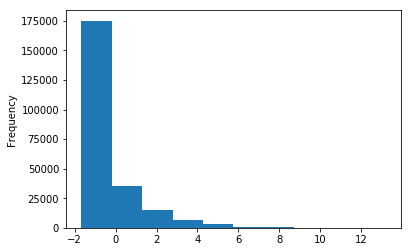

In [12]:
# Extract Click Ratio Per User

temp1 = train[['user_id', 'is_click']][~train['impression_time'].dt.day.isin([7,8,9,10,11,12,13])].groupby('user_id').is_click.count().reset_index(name='TotalAdShown')
temp2 = train[['user_id', 'is_click']][~train['impression_time'].dt.day.isin([7,8,9,10,11,12,13])].groupby('user_id').is_click.sum().reset_index(name='TotalAdClicked')
temp=pd.merge(temp1, temp2, on='user_id', how='left')
temp.info(verbose=True, null_counts=True)
temp['Click_Ratio']=temp['TotalAdClicked']/temp['TotalAdShown']
TotalAdShown=temp.TotalAdShown.sum()
TotalAdClicked=temp.TotalAdClicked.sum()
Avg_Add_Clicked=TotalAdClicked/TotalAdShown
temp['Expected_Click']=temp['TotalAdShown']*Avg_Add_Clicked
temp['Normalized_Click_Ratio']=(temp['TotalAdClicked']-temp['Expected_Click'])/(temp['Expected_Click'] ** 0.5)
train['Normalized_Click_Ratio'] = train['user_id'].map(temp[['user_id', 'Normalized_Click_Ratio']].set_index("user_id").to_dict()['Normalized_Click_Ratio'])
train['Normalized_Click_Ratio'].fillna(train['Normalized_Click_Ratio'].mean(), inplace=True)
train['Normalized_Click_Ratio'].plot.hist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 0 to 458
Data columns (total 3 columns):
app_code          459 non-null int64
TotalAdShown      459 non-null int64
TotalAdClicked    459 non-null int64
dtypes: int64(3)
memory usage: 14.3 KB


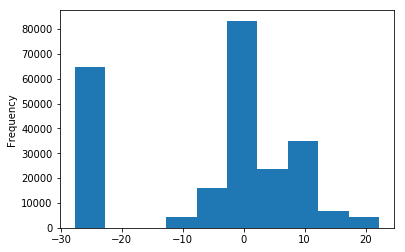

In [13]:
# Extract Click Ratio Per App

temp1 = train[['app_code', 'is_click']][~train['impression_time'].dt.day.isin([7,8,9,10,11,12,13])].groupby('app_code').is_click.count().reset_index(name='TotalAdShown')
temp2 = train[['app_code', 'is_click']][~train['impression_time'].dt.day.isin([7,8,9,10,11,12,13])].groupby('app_code').is_click.sum().reset_index(name='TotalAdClicked')
temp=pd.merge(temp1, temp2, on='app_code', how='left')
temp.info(verbose=True, null_counts=True)
temp['Click_Ratio']=temp['TotalAdClicked']/temp['TotalAdShown']
TotalAdShown=temp.TotalAdShown.sum()
TotalAdClicked=temp.TotalAdClicked.sum()
Avg_Add_Clicked=TotalAdClicked/TotalAdShown
temp['Expected_Click']=temp['TotalAdShown']*Avg_Add_Clicked
temp['Normalized_Click_Ratio']=(temp['TotalAdClicked']-temp['Expected_Click'])/(temp['Expected_Click'] ** 0.5)
train['Normalized_Click_Ratio_app'] = train['app_code'].map(temp[['app_code', 'Normalized_Click_Ratio']].set_index("app_code").to_dict()['Normalized_Click_Ratio'])
train['Normalized_Click_Ratio_app'].fillna(train['Normalized_Click_Ratio'].mean(), inplace=True)
train['Normalized_Click_Ratio_app'].plot.hist()

In [0]:
train_backup = train.copy()
test_backup= test.copy()

In [0]:
del train['impression_id']
del train['impression_time']

In [16]:
# For Checking Correlations

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train[train.loc[:, train.dtypes != np.object].columns], 500))

Top Absolute Correlations
product_type_seen_count_with_session5              item_id_seen_count_with_session5                     0.999998
product_type_seen_count_with_session4              item_id_seen_count_with_session4                     0.999998
product_type_seen_count_with_session3              item_id_seen_count_with_session3                     0.999997
product_type_seen_count_with_session2              item_id_seen_count_with_session2                     0.999995
category3_seen_count_with_session5                 product_type_seen_count_with_session5                0.999987
category3_seen_count_with_session4                 product_type_seen_count_with_session4                0.999987
category3_seen_count_with_session5                 item_id_seen_count_with_session5                     0.999984
category3_seen_count_with_session4                 item_id_seen_count_with_session4                     0.999984
category2_seen_count_with_session5                 category3_seen_coun

In [0]:
# Encoding Categorical Variables into Numerical Variables.

d = defaultdict(LabelEncoder)
Numerical_Columns = train.describe().columns.to_list()
Categorical_columns = list(set(train.columns.to_list()) - set(Numerical_Columns))
train[Categorical_columns] = train[Categorical_columns].apply(lambda x: d[x.name].fit_transform(x))

In [0]:
X_train = train.drop(['is_click','Day'],axis=1)[~train['Day'].isin([12,13])]
y_train = train['is_click'][~train['Day'].isin([12,13])]

In [0]:
columns=X_train.columns.to_list()
smt=RandomOverSampler()
X_train, y_train = smt.fit_sample(X_train, y_train)
X_train=pd.DataFrame(X_train,columns=columns)
y_train=pd.DataFrame(y_train,columns=['target'])

In [0]:
X_test = train.drop(['is_click','Day'],axis=1)[train['Day'].isin([12,13])]
y_test = train['is_click'][train['Day'].isin([12,13])]

In [0]:
x_val, x_test, y_val, y_test1 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [98]:
X_test.columns.to_list()

['user_id',
 'app_code',
 'os_version',
 'is_4G',
 'site_visit_count_last_3_hours',
 'site_visit_count_last_6_hours',
 'site_visit_count__last_12_hours',
 'site_visit_count_last_1_day',
 'site_visit_count_last_2_days',
 'site_visit_count_last_3_days',
 'site_visit_count_last_1_week',
 'site_visit_count_last_1_month',
 'category1_seen_count_last_3_hours',
 'category1_seen_count_last_6_hours',
 'category1_seen_count__last_12_hours',
 'category1_seen_count_last_1_day',
 'category1_seen_count_last_2_days',
 'category1_seen_count_last_3_days',
 'category1_seen_count_last_1_week',
 'category1_seen_count_last_1_month',
 'category2_seen_count_last_3_hours',
 'category2_seen_count_last_6_hours',
 'category2_seen_count__last_12_hours',
 'category2_seen_count_last_1_day',
 'category2_seen_count_last_2_days',
 'category2_seen_count_last_3_days',
 'category2_seen_count_last_1_week',
 'category2_seen_count_last_1_month',
 'category3_seen_count_last_3_hours',
 'category3_seen_count_last_6_hours',
 'c

In [99]:
Categorical_columns

['device_type_seen_count_with_session3',
 'os_version',
 'device_type_seen_count_with_session4',
 'part_of_the_day_seen_count_with_session2',
 'device_type_seen_count_with_session2',
 'part_of_the_day_seen_count_with_session1',
 'part_of_the_day_seen_count_with_session4',
 'device_type_seen_count_with_session1',
 'Part_of_the_day',
 'device_type_seen_count_with_session5',
 'part_of_the_day_seen_count_with_session5',
 'part_of_the_day_seen_count_with_session3']

In [0]:
col = ['user_id', 'app_code', 'os_version', 'is_4G', 'Hour_of_the_day',  'Day_Of_Week'] #0.738

In [0]:
Categorical_columns_lgbm = [ 'os_version', 'user_id', 'app_code', 'is_4G']

In [0]:
col = ['user_id',
 'app_code',
 'os_version',
 'is_4G',
 'site_visit_count_last_3_hours',
 'site_visit_count_last_6_hours',
 'site_visit_count__last_12_hours',
 'site_visit_count_last_1_day',
 'site_visit_count_last_2_days',
 'site_visit_count_last_3_days',
 'site_visit_count_last_1_week',
 'site_visit_count_last_1_month',
 'category1_seen_count_last_3_hours',
 'category1_seen_count_last_6_hours',
 'category1_seen_count__last_12_hours',
 'category1_seen_count_last_1_day',
 'category1_seen_count_last_2_days',
 'category1_seen_count_last_3_days',
 'category1_seen_count_last_1_week',
 'category1_seen_count_last_1_month',
 'category2_seen_count_last_3_hours',
 'category2_seen_count_last_6_hours',
 'category2_seen_count__last_12_hours',
 'category2_seen_count_last_1_day',
 'category2_seen_count_last_2_days',
 'category2_seen_count_last_3_days',
 'category2_seen_count_last_1_week',
 'category2_seen_count_last_1_month',
 'category3_seen_count_last_3_hours',
 'category3_seen_count_last_6_hours',
 'category3_seen_count__last_12_hours',
 'category3_seen_count_last_1_day',
 'category3_seen_count_last_2_days',
 'category3_seen_count_last_3_days',
 'category3_seen_count_last_1_week',
 'category3_seen_count_last_1_month',
 'product_type_seen_count_last_3_hours',
 'product_type_seen_count_last_6_hours',
 'product_type_seen_count__last_12_hours',
 'product_type_seen_count_last_1_day',
 'product_type_seen_count_last_2_days',
 'product_type_seen_count_last_3_days',
 'product_type_seen_count_last_1_week',
 'product_type_seen_count_last_1_month',
 'product_item_seen_count_last_3_hours',
 'product_item_seen_count_last_6_hours',
 'product_item_seen_count__last_12_hours',
 'product_item_seen_count_last_1_day',
 'product_item_seen_count_last_2_days',
 'product_item_seen_count_last_3_days',
 'product_item_seen_count_last_1_week',
 'product_item_seen_count_last_1_month',
 'category1_seen_count_with_session1',
 'category1_seen_count_with_session2',
 'category1_seen_count_with_session3',
 'category1_seen_count_with_session4',
 'category1_seen_count_with_session5',
 'category2_seen_count_with_session1',
 'category2_seen_count_with_session2',
 'category2_seen_count_with_session3',
 'category2_seen_count_with_session4',
 'category2_seen_count_with_session5',
 'category3_seen_count_with_session1',
 'category3_seen_count_with_session2',
 'category3_seen_count_with_session3',
 'category3_seen_count_with_session4',
 'category3_seen_count_with_session5',
 'product_type_seen_count_with_session1',
 'product_type_seen_count_with_session2',
 'product_type_seen_count_with_session3',
 'product_type_seen_count_with_session4',
 'product_type_seen_count_with_session5',
 'item_id_seen_count_with_session1',
 'item_id_seen_count_with_session2',
 'item_id_seen_count_with_session3',
 'item_id_seen_count_with_session4',
 'item_id_seen_count_with_session5',
 'average_price_of_product_seen_count_with_session1',
 'average_price_of_product_seen_count_with_session2',
 'average_price_of_product_seen_count_with_session3',
 'average_price_of_product_seen_count_with_session4',
 'average_price_of_product_seen_count_with_session5',
 'device_type_seen_count_with_session1',
 'device_type_seen_count_with_session2',
 'device_type_seen_count_with_session3',
 'device_type_seen_count_with_session4',
 'device_type_seen_count_with_session5',
 'hour_of_the_day_seen_count_with_session1',
 'hour_of_the_day_seen_count_with_session2',
 'hour_of_the_day_seen_count_with_session3',
 'hour_of_the_day_seen_count_with_session4',
 'hour_of_the_day_seen_count_with_session5',
 'part_of_the_day_seen_count_with_session1',
 'part_of_the_day_seen_count_with_session2',
 'part_of_the_day_seen_count_with_session3',
 'part_of_the_day_seen_count_with_session4',
 'part_of_the_day_seen_count_with_session5',
 'time_spent_surfing_each_session_with_session1',
 'time_spent_surfing_each_session_with_session2',
 'time_spent_surfing_each_session_with_session3',
 'time_spent_surfing_each_session_with_session4',
 'time_spent_surfing_each_session_with_session5',
 'last_visited_product_item1',
# 'last_visited_product_item2',
# 'last_visited_product_item3',
# 'last_visited_product_item4',
# 'last_visited_product_item5',
# 'last_visited_product_type1',
# 'last_visited_product_type2',
# 'last_visited_product_type3',
# 'last_visited_product_type4',
# 'last_visited_product_type5',
# 'last_visited_product_category1_1',
# 'last_visited_product_category1_2',
# 'last_visited_product_category1_3',
# 'last_visited_product_category1_4',
# 'last_visited_product_category1_5',
# 'last_visited_product_category2_1',
# 'last_visited_product_category2_2',
# 'last_visited_product_category2_3',
# 'last_visited_product_category2_4',
# 'last_visited_product_category2_5',
# 'last_visited_product_category3_1',
# 'last_visited_product_category3_2',
# 'last_visited_product_category3_3',
# 'last_visited_product_category3_4',
# 'last_visited_product_category3_5',
 'last_visited_product_price_1',
# 'last_visited_product_price_2',
# 'last_visited_product_price_3',
# 'last_visited_product_price_4',
# 'last_visited_product_price_5',
 'Hour_of_the_day',
 #'Part_of_the_day',
 'Day_Of_Week',
 #'Weekend',
 #'Normalized_Click_Ratio',
 #'Normalized_Click_Ratio_app0'
      ]

In [0]:
col =['user_id',
 'app_code',
 'os_version',
 'is_4G',
 'site_visit_count_last_1_week',
 'product_type_seen_count_last_3_days',
 'product_type_seen_count_with_session1',
 'item_id_seen_count_with_session1',
 'average_price_of_product_seen_count_with_session1',
 'hour_of_the_day_seen_count_with_session1',
 'time_spent_surfing_each_session_with_session1',
 'last_visited_product_price_1', 'last_visited_product_item1']                                     

In [0]:
Categorical_columns_lgbm = ['device_type_seen_count_with_session2',
 'part_of_the_day_seen_count_with_session4',
 'device_type_seen_count_with_session1',
 'device_type_seen_count_with_session5',
 'device_type_seen_count_with_session3',
 'os_version', 'user_id',
 'app_code', 'is_4G',
 'part_of_the_day_seen_count_with_session3',
 'part_of_the_day_seen_count_with_session1',
 #'Part_of_the_day',
 'part_of_the_day_seen_count_with_session5',
 'part_of_the_day_seen_count_with_session2',
 'device_type_seen_count_with_session4',
 #'last_visited_product_item1',
 #'last_visited_product_item2',
 #'last_visited_product_item3',
 #'last_visited_product_item4',
 #'last_visited_product_item5',
 #'last_visited_product_type1',
 #'last_visited_product_type2',
 #'last_visited_product_type3',
 #'last_visited_product_type4',
 #'last_visited_product_type5',
 #'last_visited_product_category1_1',
 #'last_visited_product_category1_2',
 #'last_visited_product_category1_3',
 #'last_visited_product_category1_4',
 #'last_visited_product_category1_5',
# 'last_visited_product_category2_1',
 #'last_visited_product_category2_2',
 #'last_visited_product_category2_3',
 #'last_visited_product_category2_4',
 #'last_visited_product_category2_5',
 #'last_visited_product_category3_1',
 #'last_visited_product_category3_2',
 #'last_visited_product_category3_3',
 #'last_visited_product_category3_4',
 #'last_visited_product_category3_5'
                            ]

In [0]:
Categorical_columns_lgbm = ['user_id',
 'app_code',
 'os_version',
 'is_4G',]

In [106]:
train_data = lightgbm.Dataset(X_train[col], label=y_train, categorical_feature=Categorical_columns_lgbm)
test_data = lightgbm.Dataset(x_val[col], label=y_val)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 13,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'max_depth': 17,
    'lambda': 0.05
    #'scale_pos_weight': 25
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.54687
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.546854
[3]	valid_0's auc: 0.700791
[4]	valid_0's auc: 0.700136
[5]	valid_0's auc: 0.685186
[6]	valid_0's auc: 0.674119
[7]	valid_0's auc: 0.665506
[8]	valid_0's auc: 0.708204
[9]	valid_0's auc: 0.708669
[10]	valid_0's auc: 0.704877
[11]	valid_0's auc: 0.71775
[12]	valid_0's auc: 0.723362
[13]	valid_0's auc: 0.721984
[14]	valid_0's auc: 0.721004
[15]	valid_0's auc: 0.719255
[16]	valid_0's auc: 0.723554
[17]	valid_0's auc: 0.726273
[18]	valid_0's auc: 0.729288
[19]	valid_0's auc: 0.73019
[20]	valid_0's auc: 0.730655
[21]	valid_0's auc: 0.731871
[22]	valid_0's auc: 0.730803
[23]	valid_0's auc: 0.729901
[24]	valid_0's auc: 0.731845
[25]	valid_0's auc: 0.733802
[26]	valid_0's auc: 0.733678
[27]	valid_0's auc: 0.736604
[28]	valid_0's auc: 0.737626
[29]	valid_0's auc: 0.737657
[30]	valid_0's auc: 0.738541
[31]	valid_0's auc: 0.739175
[32]	valid_0's auc: 0.738832
[33]	valid_0's auc: 0

In [107]:
lgbm_pred = model.predict(x_val[col])
print (metrics.roc_auc_score(y_val, lgbm_pred))

0.7570435713765893


In [108]:
lgbm_pred = model.predict(x_test[col])
print (metrics.roc_auc_score(y_test1, lgbm_pred))

0.7355400080824409


In [109]:
lgbm_pred = model.predict(X_test[col])
print (metrics.roc_auc_score(y_test, lgbm_pred))
lgbm_pred[lgbm_pred>0.5]=1
lgbm_pred[lgbm_pred<=0.5]=0
print (metrics.confusion_matrix(y_test, lgbm_pred))
print (metrics.accuracy_score(y_test, lgbm_pred))
print (metrics.classification_report(y_test, lgbm_pred))

0.745586202744541
[[2939  984]
 [  86  113]]
0.7404172731683649
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3923
           1       0.10      0.57      0.17       199

    accuracy                           0.74      4122
   macro avg       0.54      0.66      0.51      4122
weighted avg       0.93      0.74      0.81      4122



In [0]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), 
                               columns=['Value','Feature'])
    #plt.figure(figsize=(40, 20))
    #sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    #plt.tight_layout()
    plt.show()
    #plt.savefig('lgbm_importances-01.png')

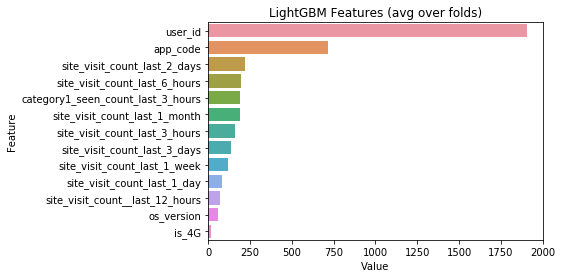

In [111]:
plotImp(model,X_train,20)

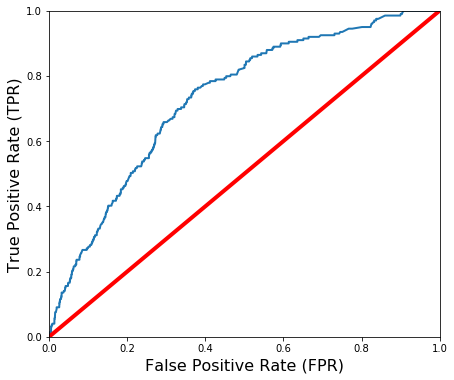

In [112]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict(X_test))

# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(7,6))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [0]:
sub = pd.read_csv("/content/drive/My Drive/Hackathon/submission/sample_submission.csv")

In [114]:
test[Categorical_columns] = test[Categorical_columns].apply(lambda x: d[x.name].transform(x))

ValueError: ignored

In [0]:
sub['is_click'] = model.predict(test[col])

In [116]:
model.predict(test[col])

array([0.35772367, 0.05833393, 0.52030794, ..., 0.08890936, 0.72066025,
       0.67627338])

In [0]:
sub.to_csv("/content/drive/My Drive/Hackathon/sample_submission.csv", index=False)